# Prueba Analista de Datos


In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def preprocesar_X(X):
    # Reemplazar valores no numéricos (ej. D4N3) por nulos.
    X = X.apply(pd.to_numeric, errors='coerce')
    # Imputar nulos con el promedio de cada columna.
    X = X.fillna(X.mean())
    # Remover columnas correlacionadas
    cols_a_remover = ['X_8','X_9','X_10','X_11','X_16','X_17','X_23','X_24','X_27','X_30']
    X = X.drop(cols_a_remover, axis=1)
    return(X)

# Lectura de datos
train_A = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Muestra/train_A.csv", sep='|')
train_B = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Muestra/train_B.csv", sep='|')
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Muestra/test_send.csv", sep='|')

# Left join
train = train_A.merge(train_B, on='ID', how='left')

# Separar X y Y
y = train.y_y.to_numpy()
X = train.filter(regex='^X',axis=1)
Xtest = test.drop(['ID'], axis=1)

# Análisis Exploratorio


In [2]:
XEDA = X

#Reemplazar valores no numéricos (ej. D4N3) por nulos.
XEDA = XEDA.apply(pd.to_numeric, errors='coerce')

# Verificación de valores nulos por columna
print(XEDA.isna().sum())

#Imputar nulos con el promedio de cada columna.
XEDA = XEDA.fillna(XEDA.mean())

X_1      5
X_2      5
X_3     23
X_4      3
X_5      2
X_6      2
X_7      5
X_8      1
X_9      1
X_10     2
X_11     0
X_12     3
X_13     0
X_14     2
X_15    11
X_16     0
X_17    29
X_18     3
X_19     4
X_20     1
X_21    78
X_22    73
X_23    71
X_24    71
X_25    77
X_26     1
X_27     1
X_28     2
X_29     2
X_30    24
dtype: int64


In [18]:
# Verificación de correlación entre columnas
corr = XEDA.corr(method='kendall')
pd.set_option('precision', 1)
corr.style.background_gradient(cmap='coolwarm')

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30
X_1,1.0,0.0,-0.0,-0.2,0.0,-0.4,0.3,-0.4,-0.2,0.3,-0.2,-0.1,-0.1,0.2,-0.1,-0.1,-0.2,-0.0,-0.2,0.0,-0.1,0.2,1.0,0.2,0.1,0.2,0.0,0.2,-0.1,1.0
X_2,0.0,1.0,-0.0,-0.0,-0.2,-0.2,0.0,-0.2,-0.0,0.0,-0.0,0.1,-0.0,0.0,0.2,-0.0,-0.0,0.0,-0.3,0.0,-0.3,-0.1,0.0,0.0,0.3,0.1,-0.2,0.1,0.1,0.0
X_3,-0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
X_4,-0.2,-0.0,-0.0,1.0,0.0,0.1,-0.6,0.1,1.0,-0.6,1.0,0.3,0.2,0.1,0.0,0.2,1.0,0.0,-0.1,-0.4,0.2,-0.4,-0.2,0.1,0.2,-0.0,0.0,-0.1,0.1,-0.2
X_5,0.0,-0.2,0.0,0.0,1.0,-0.2,-0.2,-0.2,0.0,-0.2,0.0,0.0,-0.0,-0.3,-0.3,-0.0,0.0,-0.0,0.3,0.3,0.4,0.3,0.0,-0.3,-0.5,-0.2,1.0,-0.4,-0.2,0.0
X_6,-0.4,-0.2,0.0,0.1,-0.2,1.0,-0.0,1.0,0.1,-0.0,0.1,-0.1,0.1,0.2,0.3,0.1,0.1,0.0,0.1,-0.0,-0.1,-0.3,-0.4,0.2,0.2,0.1,-0.2,0.3,0.4,-0.4
X_7,0.3,0.0,0.0,-0.6,-0.2,-0.0,1.0,-0.0,-0.6,1.0,-0.6,-0.4,-0.2,0.3,0.2,-0.2,-0.6,-0.0,-0.2,-0.0,-0.3,0.2,0.3,0.3,0.1,0.2,-0.2,0.5,0.0,0.3
X_8,-0.4,-0.2,0.0,0.1,-0.2,1.0,-0.0,1.0,0.1,-0.0,0.1,-0.1,0.1,0.2,0.3,0.1,0.1,0.0,0.1,-0.0,-0.1,-0.3,-0.4,0.2,0.2,0.1,-0.2,0.3,0.4,-0.4
X_9,-0.2,-0.0,-0.0,1.0,0.0,0.1,-0.6,0.1,1.0,-0.6,1.0,0.3,0.2,0.1,0.0,0.2,1.0,0.0,-0.1,-0.4,0.2,-0.4,-0.2,0.1,0.2,-0.0,0.0,-0.1,0.1,-0.2
X_10,0.3,0.0,0.0,-0.6,-0.2,-0.0,1.0,-0.0,-0.6,1.0,-0.6,-0.4,-0.2,0.3,0.2,-0.2,-0.6,-0.0,-0.2,-0.0,-0.3,0.2,0.3,0.3,0.1,0.2,-0.2,0.5,0.0,0.3


# Entrenamiento Modelo 1: Gradient-boosted decision trees

In [3]:
pd.set_option('precision', 4)
X = preprocesar_X(X)

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.0575,0.0021,0.1171,0.0218
1,0.0467,0.0013,0.1039,0.0201
2,0.0397,0.0013,0.0944,0.0191
3,0.0338,0.0009,0.0853,0.0181
4,0.0298,0.0009,0.0833,0.0163
...,...,...,...,...
75,0.0000,0.0000,0.0517,0.0100
76,0.0000,0.0000,0.0520,0.0103
77,0.0000,0.0000,0.0519,0.0108
78,0.0000,0.0000,0.0519,0.0102


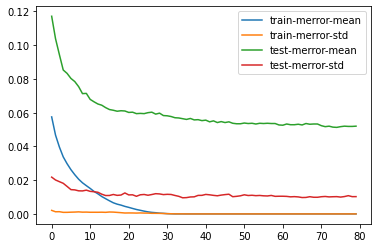

In [4]:
import xgboost as xgb

#***** Parametros de los árboles *****
num_arboles = 80
profundidad_arbol = 8
#*************************************

dtrain = xgb.DMatrix(X, label=y)
param = {'objective':'multi:softprob', 'num_class':3, 'eta':0.3, 'max_depth':profundidad_arbol}
history = xgb.cv(params=param, dtrain=dtrain, num_boost_round=num_arboles, nfold=20, verbose_eval=False)
history.plot()
history

# Entrenamiento modelo 2: Multi-layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate 

#***** Parametros de la red neuronal *****
epocas = 500
capas_ocultas = (100) # num neuronas por cada capa oculta
#*************************************

nn = MLPClassifier(solver='adam', activation='logistic', max_iter=epocas, tol=0.001, n_iter_no_change=20,
                   hidden_layer_sizes=capas_ocultas, learning_rate='adaptive', verbose=True)
cv_results = cross_validate(nn, X, y, cv=20, return_train_score=False) 

In [6]:
score = cv_results['test_score'].mean()
print(score, 1-score)

0.9598571428571429 0.04014285714285715


,fit_time,score_time,test_score
0,10.3830,0.0053,0.9571
1,11.6205,0.0042,0.9543
2,9.5714,0.0041,0.9714
3,11.6779,0.0050,0.9743
4,11.2013,0.0042,0.9686
5,12.5449,0.0043,0.9686
6,9.7239,0.0040,0.9543
7,16.2449,0.0042,0.9543
8,11.1564,0.0055,0.9657
9,9.5137,0.0046,0.9571


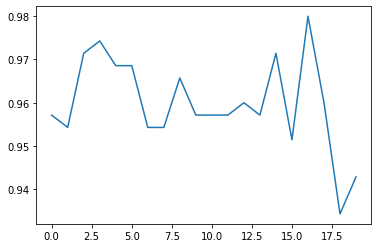

In [13]:
import matplotlib.pyplot as plt
plt.plot(cv_results['test_score'])
pd.DataFrame(cv_results)

# Predicción en Test

In [ ]:
Xtest = preprocesar_X(Xtest)

In [22]:
bst = xgb.train(params=param, dtrain=dtrain, num_boost_round=num_arboles)
dtest = xgb.DMatrix(Xtest)
y_pred1 = bst.predict(dtest)
y_pred1 = pd.DataFrame(y_pred1).idxmax(axis=1).to_numpy()
y_pred1

array([1, 1, 1, ..., 1, 1, 2])

In [24]:
nn = MLPClassifier(solver='adam', activation='logistic', max_iter=epocas, tol=0.001, n_iter_no_change=20,
                   hidden_layer_sizes=capas_ocultas, learning_rate='adaptive', verbose=True)
nn = nn.fit(X, y)
y_pred2 = nn.predict(Xtest)
y_pred2

Iteration 1, loss = 0.87709288
Iteration 2, loss = 0.65643520
Iteration 3, loss = 0.56937505
Iteration 4, loss = 0.52679665
Iteration 5, loss = 0.50502525
Iteration 6, loss = 0.49159122
Iteration 7, loss = 0.48181268
Iteration 8, loss = 0.47282152
Iteration 9, loss = 0.46496080
Iteration 10, loss = 0.45529477
Iteration 11, loss = 0.44607373
Iteration 12, loss = 0.43629650
Iteration 13, loss = 0.42695644
Iteration 14, loss = 0.41679743
Iteration 15, loss = 0.40699040
Iteration 16, loss = 0.39769739
Iteration 17, loss = 0.38990379
Iteration 18, loss = 0.37971507
Iteration 19, loss = 0.37130766
Iteration 20, loss = 0.36185512
Iteration 21, loss = 0.35410035
Iteration 22, loss = 0.34576623
Iteration 23, loss = 0.33793255
Iteration 24, loss = 0.33054082
Iteration 25, loss = 0.32374091
Iteration 26, loss = 0.31600182
Iteration 27, loss = 0.30931475
Iteration 28, loss = 0.30241252
Iteration 29, loss = 0.29615011
Iteration 30, loss = 0.29061879
Iteration 31, loss = 0.28370513
Iteration 32, los

array([1, 1, 1, ..., 1, 1, 2])

In [32]:
resultado_final = pd.DataFrame({'ID':test['ID'], 'y_pred1':y_pred1, 'y_pred2':y_pred2})
resultado_final.to_csv("/content/drive/MyDrive/Colab Notebooks/Muestra/resultado_final.csv", index=False)